We decompose our problem according to the following flowchart: 
```mermaid
graph TD
    A[Start] --> B[Read csv file to create a list of dictionaries representing each student];
    B --> C[For each tutorial grp, create 5 CGPA bands separately for each gender];
    C --> D[Determine gender ratio target for each tutorial grp];
    D --> E[Assign 1 person from each CGPA band to each grp of 5, respecting the gender target];
    E --> F[End];

In [2]:

import csv
import itertools
import os
import random
import sys


def read_students(start_index=0, count=50, filepath="records.csv"):
    """Read up to count students starting from start_index (after header).
    Returns a list of student dicts with keys: tutorial group, id, school, name, gender, gpa
    """
    students = []

    with open(filepath, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader, None)  # skip header if present

        # skip start_index rows
        for _ in range(start_index):
            try:
                next(reader)
            except StopIteration:
                return students

        for _ in range(count):
            try:
                row = next(reader)
            except StopIteration:
                break
            if len(row) < 6:
                # skip malformed line
                continue
            try:
                gpa = float(row[5])
            except Exception:
                # skip rows with non-numeric GPA
                continue

            student = {
                'tutorial group': row[0].strip(),
                'id': row[1].strip(),
                'school': row[2].strip(),
                'name': row[3].strip(),
                'gender': row[4].strip(),
                'gpa': gpa,
            }
            students.append(student)

    return students
read_students(start_index=0, count=50, filepath="records.csv")


[{'tutorial group': 'G-1',
  'id': '5002',
  'school': 'CCDS',
  'name': 'Aarav Singh',
  'gender': 'Male',
  'gpa': 4.02},
 {'tutorial group': 'G-1',
  'id': '3838',
  'school': 'EEE',
  'name': 'Aarti Nair',
  'gender': 'Female',
  'gpa': 4.05},
 {'tutorial group': 'G-1',
  'id': '2091',
  'school': 'EEE',
  'name': 'Adlan Bin Rahman',
  'gender': 'Male',
  'gpa': 4.2},
 {'tutorial group': 'G-1',
  'id': '288',
  'school': 'CoB (NBS)',
  'name': 'Ajay Verma',
  'gender': 'Male',
  'gpa': 4.01},
 {'tutorial group': 'G-1',
  'id': '4479',
  'school': 'CCDS',
  'name': 'Amelia Kim',
  'gender': 'Female',
  'gpa': 4.11},
 {'tutorial group': 'G-1',
  'id': '5708',
  'school': 'SoH',
  'name': 'Ananya Ramesh',
  'gender': 'Male',
  'gpa': 4.2},
 {'tutorial group': 'G-1',
  'id': '4563',
  'school': 'WKW SCI',
  'name': 'Anjali Patel',
  'gender': 'Female',
  'gpa': 4.01},
 {'tutorial group': 'G-1',
  'id': '3989',
  'school': 'WKW SCI',
  'name': 'Anthony Liu',
  'gender': 'Male',
  'gpa':

Count_total_students function:
1. Prevents FileNotFound error and returns 0 since there are no students to count.
2. Opening the file using a with statement (context manager), specifying UTF-8 encoding to handle special characters
3. Sets newline = '' to properly handle CSV file across different operating system (os)
4. csv.reader() to read the file line by line, would stop once the file ran out of lines
5. Skips the header to prevent overcounting the header as students
6. return sum(1 for row in reader) -- for each time a CSV reader goes through a row, an integer 1 would be generated. This line sums up all the 1's, which would effectively count all the rows

This function is:
a) memory efficient (as it does not load all the rows into the system memory)
b) fast 
c) It would stop automatically

In [3]:

def count_total_students(filepath="records.csv"):
    """Count total number of student records (excluding header)."""        
    if not os.path.exists(filepath):
        return 0
        
    with open(filepath, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        headers = next(reader, None)  # skip header
        return sum(1 for row in reader)
        
count_total_students(filepath="records.csv")

6000

In [8]:
def form_groups(students, num_groups=10):
    """Form groups from a list of student dicts.
    Returns list of groups (each group is a list of students).
    """
    if not students:
        return []

    students_sorted = sorted(students, key=lambda x: x['gpa'], reverse=True)

    # split into up to 5 bands as evenly as possible
    n = len(students_sorted)
    band_size = max(1, n // 5)
    bands = [students_sorted[i:i + band_size] for i in range(0, n, band_size)]

    # split each band by gender
    band_males = []
    band_females = []
    for band in bands:
        males = [s for s in band if s['gender'].strip().lower() in ('m', 'male')]
        females = [s for s in band if s['gender'].strip().lower() in ('f', 'female')]
        random.shuffle(males)
        random.shuffle(females)
        band_males.append(males)
        band_females.append(females)

    total_males = sum(len(m) for m in band_males)
    total_females = sum(len(f) for f in band_females)
    
    if total_males > total_females:
        target_males_per_group, target_females_per_group = 3, 2
    else:
        target_males_per_group, target_females_per_group = 2, 3

    groups = [[] for _ in range(num_groups)]
    male_count = [0] * num_groups
    female_count = [0] * num_groups

    # distribute one student from each band into each group
    for band_idx in range(len(bands)):
        for group_idx in range(num_groups):
            # try to pick a student to respect the gender targets
            picked = False
            if male_count[group_idx] < target_males_per_group and band_males[band_idx]:
                groups[group_idx].append(band_males[band_idx].pop())
                male_count[group_idx] += 1
                picked = True
            elif female_count[group_idx] < target_females_per_group and band_females[band_idx]:
                groups[group_idx].append(band_females[band_idx].pop())
                female_count[group_idx] += 1
                picked = True
            elif band_males[band_idx]:
                groups[group_idx].append(band_males[band_idx].pop())
                male_count[group_idx] += 1
                picked = True
            elif band_females[band_idx]:
                groups[group_idx].append(band_females[band_idx].pop())
                female_count[group_idx] += 1
                picked = True

    return groups


In [9]:

def print_groups(groups, students_sorted, bands, batch_number=1):
    """Print groups with band information."""
    # Precompute band assignments for faster lookup
    student_to_band = {}
    for band_idx, band in enumerate(bands):
        for student in band:
            # Use a unique identifier (name + id) to handle duplicate names
            student_key = f"{student['name']}_{student['id']}"
            student_to_band[student_key] = band_idx + 1  # Band 1 = highest GPA

    print(f"=== BATCH {batch_number} ===")
    print(f"Total students in this batch: {len(students_sorted)}")
    print()
    
    for i, g in enumerate(groups, 1):
        print(f"Group {i}:")
        males_in_group = 0
        females_in_group = 0
        total_gpa = 0.0
        
        for student in g:
            # Determine which band the student came from
            student_key = f"{student['name']}_{student['id']}"
            band_number = student_to_band.get(student_key, "Unknown")
            
            gender_lower = student['gender'].lower()
            if gender_lower in ['m','male']:
                males_in_group += 1
            elif gender_lower in ['f', 'female']:
                females_in_group += 1
            total_gpa += student['gpa']
            print(f"  {student['name']} | {student['school']} | {student['gender']} | GPA: {student['gpa']:.2f} | Band: {band_number}")
        
        if g:
            avg_gpa = total_gpa / len(g)
            print(f"  Summary: {males_in_group} males, {females_in_group} females, Average GPA: {avg_gpa:.2f}")
        else:
            print("  Summary: Empty group")
        
        print()
print_groups(groups, students_sorted, bands, batch_number=1)

=== BATCH 1 ===
Total students in this batch: 50

Group 1:
  Ronin Huang | EEE | Male | GPA: 4.15 | Band: 1
  Michael Walker | CoE | Male | GPA: 4.14 | Band: 2
  Ruby Nelson | CCDS | Female | GPA: 4.08 | Band: 3
  Farah Binti Omar | CCEB | Female | GPA: 4.00 | Band: 4
  Aki Yoshida | MAE | Female | GPA: 3.90 | Band: 5
  Summary: 2 males, 3 females, Average GPA: 4.05

Group 2:
  Zachary Chen | EEE | Male | GPA: 4.19 | Band: 1
  Rafael De Leon | MSE | Male | GPA: 4.11 | Band: 2
  Ella Santos | SoH | Female | GPA: 4.03 | Band: 3
  Aaliyah Howard | CoB (NBS) | Female | GPA: 4.00 | Band: 4
  Natalia Fedorova | SSS | Female | GPA: 4.00 | Band: 5
  Summary: 2 males, 3 females, Average GPA: 4.07

Group 3:
  William Yang | CoE | Male | GPA: 4.20 | Band: 1
  Ikram Tan | CCDS | Male | GPA: 4.11 | Band: 2
  Aria Wadhwa | EEE | Female | GPA: 4.03 | Band: 3
  Sana Tan | EEE | Female | GPA: 4.02 | Band: 4
  Naoko Ueda | MSE | Female | GPA: 3.86 | Band: 5
  Summary: 2 males, 3 females, Average GPA: 4.

In [10]:
def print_groups(groups, students_sorted, bands, batch_number=1):
    """Print groups with student details and band information."""
    print(f"\n=== Tutorial Group Distribution ===")
    
    # Create band lookup for this batch
    student_to_band = {}
    for band_idx, band in enumerate(bands):
        for student in band:
            student_key = f"{student['name']}_{student['id']}"
            student_to_band[student_key] = band_idx + 1
    
    # Group students by their tutorial groups
    tutorial_groups_dict = {}
    for student in students_sorted:
        tutorial_group = student['tutorial group']
        if tutorial_group not in tutorial_groups_dict:
            tutorial_groups_dict[tutorial_group] = []
        tutorial_groups_dict[tutorial_group].append(student)
    
    # Print groups organized by tutorial group
    for tutorial_group, group_students in sorted(tutorial_groups_dict.items()):
        print(f"\n--- Tutorial Group: {tutorial_group} ---")
        
        if not group_students:
            print("  No students in this tutorial group")
            continue
            
        total_gpa = 0.0
        male_count = 0
        female_count = 0
        
        for student in group_students:
            # Determine which band the student came from
            student_key = f"{student['name']}_{student['id']}"
            band_number = student_to_band.get(student_key, "Unknown")
            
            gender_lower = student['gender'].lower()
            if gender_lower in ('m', 'male'):
                gender_display = 'M'
                male_count += 1
            elif gender_lower in ('f', 'female'):
                gender_display = 'F'
                female_count += 1
            else:
                gender_display = student['gender']
            
            print(f"  {student['name']} (ID: {student['id']}, "
                  f"School: {student['school']}, Gender: {gender_display}, "
                  f"GPA: {student['gpa']:.2f}, Band: {band_number}, "
                  f"Team: {student.get('team_assigned', 'Not assigned')})")
            
            total_gpa += student['gpa']
        
        avg_gpa = total_gpa / len(group_students) if group_students else 0
        print(f"  Summary: {len(group_students)} students "
              f"(M: {male_count}, F: {female_count}), "
              f"Average GPA: {avg_gpa:.2f}")
        

In [11]:
if __name__ == "__main__":
    BATCH_SIZE = 50
    NUM_GROUPS = 10
    all_groups_data = []
    
    try:
        # Count total students first
        total_students = count_total_students()
        if total_students == 0:
            print("No student records found in the file.")
            sys.exit(1)
            
        print(f"Total students in file: {total_students}")
        print(f"Processing in batches of {BATCH_SIZE} students...")
        print("=" * 60)
        
        batch_number = 1
        start_index = 0
        
        # Process file in batches until all students are processed
        while True:
            print(f"Reading students {start_index + 1} to {start_index + BATCH_SIZE}...")
            students = read_students(start_index, BATCH_SIZE)
            
            if not students:
                print("No more students to process.")
                break
                
            print(f"Processing {len(students)} students...")
            
            # Sort students for band creation
            students_sorted = sorted(students, key=lambda x: x['gpa'], reverse=True)
            n = len(students_sorted)
            band_size = max(1, n // 5)
            bands = [students_sorted[i:i + band_size] for i in range(0, n, band_size)]

            # Form groups for this batch
            groups = form_groups(students, num_groups=NUM_GROUPS)
            
            # Print groups for this batch (without batch number)
            print_groups(groups, students_sorted, bands)

            all_groups_data.append((batch_number, groups, students_sorted, bands))
            
            # Update for next batch
            start_index += BATCH_SIZE
            batch_number += 1
            
            # Add separator between batches
            if start_index < total_students:
                print("=" * 60)
                print()
        
        # Save to CSV after all batches are processed
        if all_groups_data:
            save_groups_to_csv(all_groups_data, "student_groups.csv")
            print(f"All groups have been saved to 'student_groups.csv'")
        else:
            print("No group data to save.")
        
        print(f"Processing complete! Processed {batch_number - 1} batch(es) total.")
        
    except FileNotFoundError as e:
        print(e)
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred: {e}")
        sys.exit(1)

Total students in file: 6000
Processing in batches of 50 students...
Reading students 1 to 50...
Processing 50 students...

=== Tutorial Group Distribution ===

--- Tutorial Group: G-1 ---
  Layla Torres (ID: 3861, School: ASE, Gender: F, GPA: 4.52, Band: 1, Team: Not assigned)
  Kathy Lau (ID: 2069, School: SSS, Gender: F, GPA: 4.48, Band: 1, Team: Not assigned)
  Nisha Das (ID: 809, School: CoB (NBS), Gender: F, GPA: 4.26, Band: 1, Team: Not assigned)
  Meera Singh (ID: 4820, School: CoE, Gender: F, GPA: 4.22, Band: 1, Team: Not assigned)
  Sana Jain (ID: 4338, School: SPMS, Gender: F, GPA: 4.22, Band: 1, Team: Not assigned)
  Adlan Bin Rahman (ID: 2091, School: EEE, Gender: M, GPA: 4.20, Band: 1, Team: Not assigned)
  Ananya Ramesh (ID: 5708, School: SoH, Gender: M, GPA: 4.20, Band: 1, Team: Not assigned)
  Maria Ivanovna (ID: 659, School: SSS, Gender: F, GPA: 4.20, Band: 1, Team: Not assigned)
  Areeba Khan (ID: 1383, School: CoB (NBS), Gender: F, GPA: 4.19, Band: 1, Team: Not assi

SystemExit: 1

## 6) **Objective**: To create "diverse" groups based on three criterias: GPA, gender and schools.

### **i) GPA Distribution:**
- The GPA spread shows a roughly **normal distribution** centered around **4.1**
- **Bands** were used to group students evenly by academic performance


### **ii) Gender Distribution:**
- Males and females are fairly balanced across the dataset  
- This ensures gender diversity when forming groups using the automated grouping algorithm


### **iii) School Distribution:**
- Students come from **18 different schools**
- Inter-school collaboration opportunities exist by pairing students from different faculties




## **Summary and Remarks:**
**There is diversity in gender, school, and GPA in the dataset, therefore allowing fair team formation.**




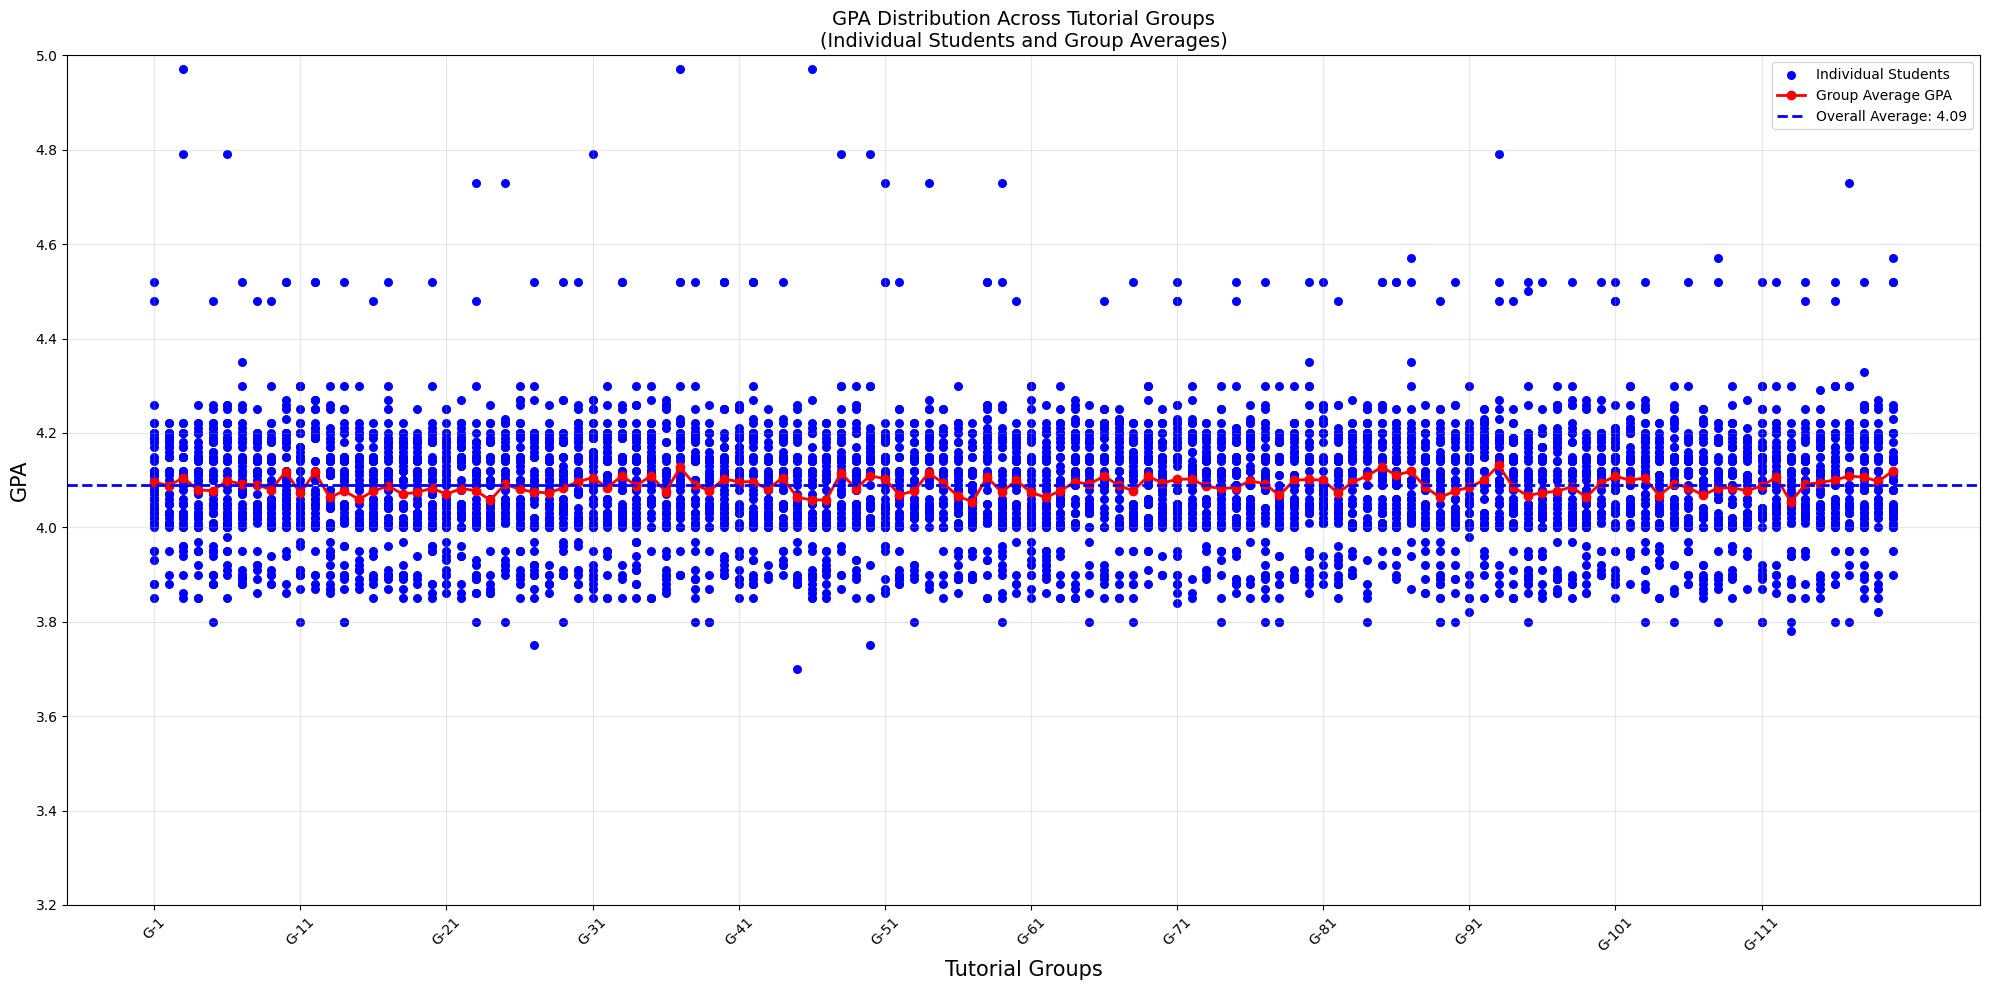

STATISTICAL SUMMARY
Total Students: 6000
Total Tutorial Groups: 120
Overall Average GPA: 4.089
Minimum GPA: 3.700
Maximum GPA: 4.970

Tutorial Group GPA Statistics:
Average group mean GPA: 4.089
Lowest group average: 4.054
Highest group average: 4.131

Sample Group Averages:
  G-1: 4.096
  G-2: 4.089
  G-3: 4.105
  G-4: 4.079
  G-5: 4.078
  ...
  G-118: 4.106
  G-119: 4.097
  G-120: 4.120


In [27]:
import matplotlib.pyplot as plt
import csv

# Read data from records.csv file
tutorial_groups = []
gpas = []

with open('records.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        tutorial_groups.append(row['Tutorial Group'])
        gpas.append(float(row['CGPA']))  # Using CGPA column for GPA

# Organize data by tutorial group
group_data = {}
for i, group in enumerate(tutorial_groups):
    if group not in group_data:
        group_data[group] = []
    group_data[group].append(gpas[i])

# Calculate statistics for each tutorial group
sorted_groups = sorted(group_data.keys(), key=lambda x: int(x.split('-')[1]))
group_means = []
group_mins = []
group_maxs = []
all_student_gpas = []

# Prepare data for plotting
x_positions = []
y_gpas = []
group_labels = []

for i, group in enumerate(sorted_groups):
    group_gpas = group_data[group]
    
    # Add individual student points
    for gpa in group_gpas:
        x_positions.append(i)
        y_gpas.append(gpa)
        all_student_gpas.append(gpa)
    
    # Calculate group statistics
    group_means.append(sum(group_gpas) / len(group_gpas))
    group_mins.append(min(group_gpas))
    group_maxs.append(max(group_gpas))
    group_labels.append(group)

# Create the visualization
plt.figure(figsize=(20, 10))

# Plot individual student GPAs as scatter points with transparency
plt.scatter(x_positions, y_gpas, alpha=1.0, color='blue', s=30, label='Individual Students')

# Plot tutorial group average GPAs as red line
plt.plot(range(len(sorted_groups)), group_means, 'ro-', 
         linewidth=2, markersize=6, label='Group Average GPA')

# Customize the plot
plt.xlabel('Tutorial Groups', fontsize=15)
plt.ylabel('GPA', fontsize=15)
plt.title('GPA Distribution Across Tutorial Groups\n(Individual Students and Group Averages)', fontsize=14)

# Set x-axis labels to show every 10th tutorial group for readability
x_ticks = list(range(0, len(sorted_groups), 10))
x_labels = [sorted_groups[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45)

# Set y-axis range from min_gpa-0.5 to 5
min_gpa = min(all_student_gpas)
plt.ylim(min_gpa - 0.5, 5.0)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend()

# Add horizontal line for overall average
overall_mean = sum(all_student_gpas) / len(all_student_gpas)
plt.axhline(y=overall_mean, color='blue', linestyle='--', 
            linewidth=2, alpha=1.0, label=f'Overall Average: {overall_mean:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

# Print statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(f"Total Students: {len(all_student_gpas)}")
print(f"Total Tutorial Groups: {len(sorted_groups)}")
print(f"Overall Average GPA: {overall_mean:.3f}")
print(f"Minimum GPA: {min(all_student_gpas):.3f}")
print(f"Maximum GPA: {max(all_student_gpas):.3f}")

# Print group statistics
print(f"\nTutorial Group GPA Statistics:")
print(f"Average group mean GPA: {sum(group_means)/len(group_means):.3f}")
print(f"Lowest group average: {min(group_means):.3f}")
print(f"Highest group average: {max(group_means):.3f}")

# Show some sample groups with their averages
print(f"\nSample Group Averages:")
for i in range(min(5, len(sorted_groups))):
    print(f"  {sorted_groups[i]}: {group_means[i]:.3f}")
if len(sorted_groups) > 5:
    print("  ...")
    for i in range(len(sorted_groups)-3, len(sorted_groups)):
        print(f"  {sorted_groups[i]}: {group_means[i]:.3f}")

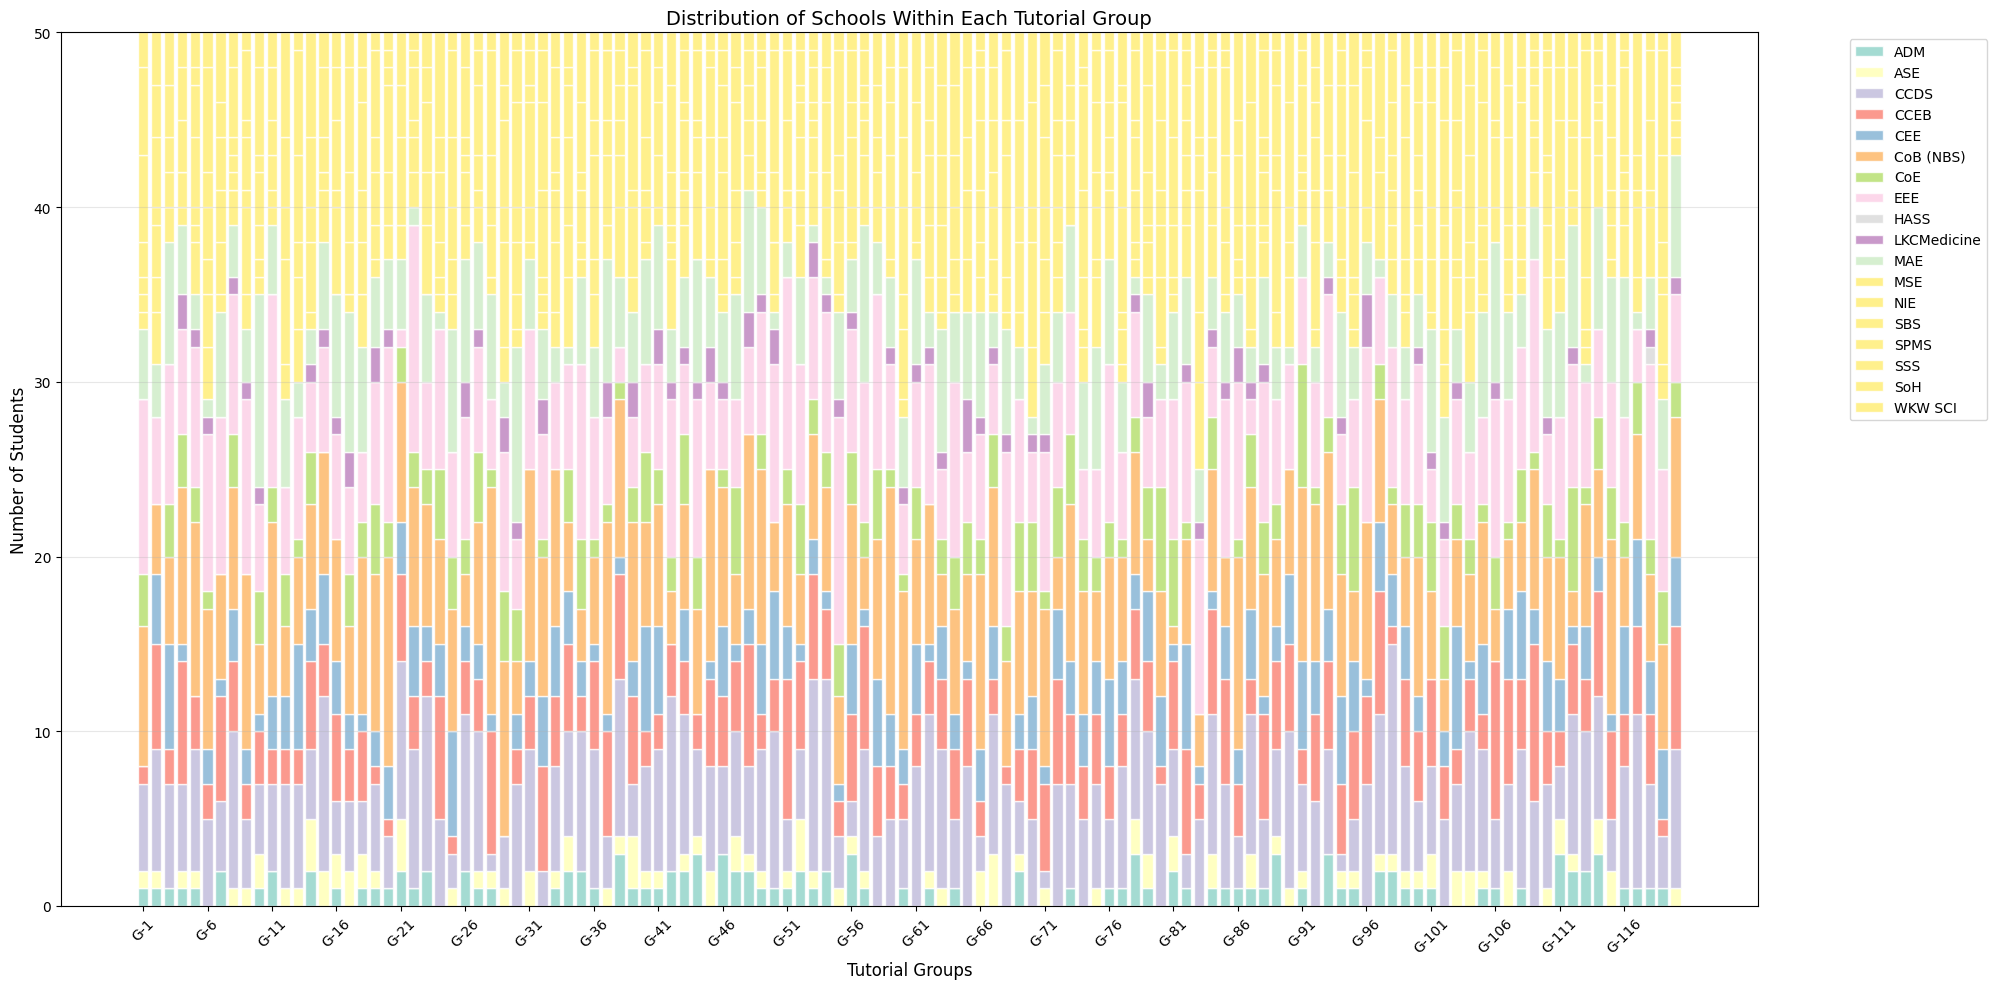

STATISTICAL SUMMARY
Total Tutorial Groups: 120
Total Schools: 18
Schools: ADM, ASE, CCDS, CCEB, CEE, CoB (NBS), CoE, EEE, HASS, LKCMedicine, MAE, MSE, NIE, SBS, SPMS, SSS, SoH, WKW SCI

School Distribution Across Tutorial Groups:
  ADM: 116 students across 78 tutorial groups
  ASE: 104 students across 72 tutorial groups
  CCDS: 702 students across 120 tutorial groups
  CCEB: 465 students across 119 tutorial groups
  CEE: 321 students across 112 tutorial groups
  CoB (NBS): 793 students across 120 tutorial groups
  CoE: 275 students across 105 tutorial groups
  EEE: 788 students across 120 tutorial groups
  HASS: 1 students across 1 tutorial groups
  LKCMedicine: 83 students across 64 tutorial groups
  MAE: 512 students across 120 tutorial groups
  MSE: 156 students across 86 tutorial groups
  NIE: 199 students across 93 tutorial groups
  SBS: 302 students across 113 tutorial groups
  SPMS: 276 students across 109 tutorial groups
  SSS: 425 students across 119 tutorial groups
  SoH: 332

In [28]:
import matplotlib.pyplot as plt
import csv
from collections import defaultdict

# Read data from records.csv file
tutorial_school_counts = defaultdict(lambda: defaultdict(int))

with open('records.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        tutorial_group = row['Tutorial Group']
        school = row['School']
        tutorial_school_counts[tutorial_group][school] += 1

# Get all unique schools and tutorial groups
all_schools = set()
all_tutorial_groups = sorted(tutorial_school_counts.keys(), key=lambda x: int(x.split('-')[1]))

for tutorial_group in tutorial_school_counts:
    all_schools.update(tutorial_school_counts[tutorial_group].keys())

all_schools = sorted(list(all_schools))

# Prepare data for stacked bar chart
tutorial_groups = []
school_data = {school: [] for school in all_schools}

for tutorial_group in all_tutorial_groups:
    tutorial_groups.append(tutorial_group)
    total_in_group = sum(tutorial_school_counts[tutorial_group].values())
    
    for school in all_schools:
        count = tutorial_school_counts[tutorial_group].get(school, 0)
        school_data[school].append(count)

# Create the stacked bar chart
plt.figure(figsize=(20, 10))

# Create stacked bars
bottom = [0] * len(tutorial_groups)
colors = plt.cm.Set3(range(len(all_schools)))

for i, school in enumerate(all_schools):
    plt.bar(tutorial_groups, school_data[school], bottom=bottom, 
            label=school, color=colors[i], alpha=0.8, edgecolor='white')
    bottom = [bottom[j] + school_data[school][j] for j in range(len(tutorial_groups))]

# Customize the plot
plt.xlabel('Tutorial Groups', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.title('Distribution of Schools Within Each Tutorial Group', fontsize=14)

# Rotate x-axis labels and show only every 5th label for readability
x_ticks = list(range(0, len(tutorial_groups), 5))
x_labels = [tutorial_groups[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistical summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(f"Total Tutorial Groups: {len(tutorial_groups)}")
print(f"Total Schools: {len(all_schools)}")
print(f"Schools: {', '.join(all_schools)}")

print(f"\nSchool Distribution Across Tutorial Groups:")
for school in all_schools:
    total_students = sum(school_data[school])
    groups_with_students = sum(1 for count in school_data[school] if count > 0)
    print(f"  {school}: {total_students} students across {groups_with_students} tutorial groups")

# Show sample distribution for first few tutorial groups
print(f"\nSample Distribution (First 5 Tutorial Groups):")
for i in range(min(5, len(tutorial_groups))):
    print(f"  {tutorial_groups[i]}:")
    for school in all_schools:
        count = school_data[school][i]
        if count > 0:
            print(f"    {school}: {count} students")

RV- 6) Objective: To analyze and visualize diversity among students in the dataset using three main indicators — gender, school, and GPA range.
i) Gender Distribution: 
- Males and females are fairly balanced across the dataset.  
- This ensures gender diversity when forming groups using the automated grouping algorithm.
ii) School Distribution: 
- Students come from 18 different schools. 
- Inter-school collaboration opportunities exist by pairing students from different faculties.
iii) GPA Distribution:
- The GPA spread shows a roughly normal distribution centered around 4.1.  
- Bands were used to group students evenly by academic performance.
Summary and Remarks:
There is diversity in gender, school, and gpa in the dataset, therefore allowing fair team formation.